<a href="https://colab.research.google.com/github/alfredqbit/NU-DDS-8515/blob/main/sepulvedaADDS-8515-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PCA and Logistic Regression on the UCI Wine Dataset

This notebook implements the steps described in the LaTeX report:
- Load and explore the UCI Wine dataset
- Standardize features
- Compute PCA (covariance, eigenvalues, eigenvectors)
- Visualize eigenvalues (scree plot) and PC scores
- Train logistic regression on original features
- Train logistic regression on PCA-transformed features
- Compare performance and simple training times

In [59]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.pipeline import Pipeline
import time


# Make plots a bit larger
plt.rcParams["figure.figsize"] = (6, 4)
# Create figures directory
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

Step 1: Dataset Selection, Loading, and EDA

In [60]:
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

print("Shape:", df.shape)
print("\nHead:")
display(df.head())

print("\nInfo:")
print(df.info())

print("\nSummary statistics:")
display(df.describe())

print("\nClass distribution:")
print(df["target"].value_counts().sort_index(), " (classes:", list(target_names), ")")

print("\nMissing values per column:")
print(df.isnull().sum())

Shape: (178, 14)

Head:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000



Class distribution:
target
0    59
1    71
2    48
Name: count, dtype: int64  (classes: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')] )

Missing values per column:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64



For this dataset, there are no missing values. We will still standardize
all numerical features before performing PCA and training the classifier.

Step 2: Standardization (for PCA exploration)


In [61]:
scaler_full = StandardScaler()
Z = scaler_full.fit_transform(X)  # standardized features for PCA visualization

Z_df = pd.DataFrame(Z, columns=feature_names)
display(Z_df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


Step 3: PCA Computation (Covariance, Eigenvalues, Scree Plot)

Covariance matrix shape: (13, 13)
Eigenvalues (descending):
[4.73243698 2.51108093 1.45424187 0.92416587 0.85804868 0.64528221
 0.55414147 0.35046627 0.29051203 0.25232001 0.22706428 0.16972374
 0.10396199]

Proportion of variance explained:
[0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019 0.01736836 0.01298233
 0.00795215]

Cumulative proportion:
[0.36198848 0.55406338 0.66529969 0.73598999 0.80162293 0.85098116
 0.89336795 0.92017544 0.94239698 0.96169717 0.97906553 0.99204785
 1.        ]


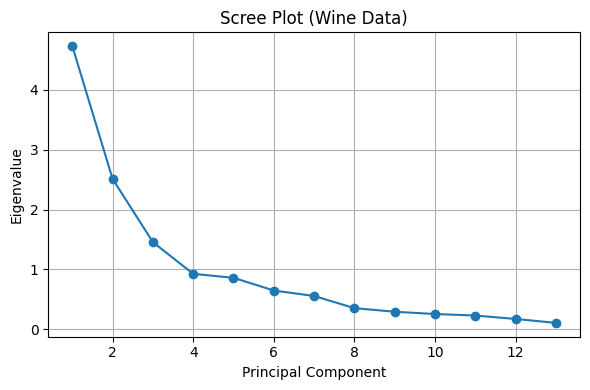

In [62]:
# Covariance matrix of standardized data
S = np.cov(Z.T)
print("Covariance matrix shape:", S.shape)

# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(S)  # eigh since S is symmetric
# Sort in descending order
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("Eigenvalues (descending):")
print(eigvals)

explained_var = eigvals / eigvals.sum()
cum_explained_var = np.cumsum(explained_var)

print("\nProportion of variance explained:")
print(explained_var)
print("\nCumulative proportion:")
print(cum_explained_var)

# Scree plot from manual eigenvalues
plt.figure()
plt.plot(range(1, len(eigvals) + 1), eigvals, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot (Wine Data)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "scree_plot.png"), dpi=300)
plt.show()

Compute PCA with scikit-learn to obtain scores and compare explained variance.


In [63]:
pca_full = PCA()
pca_full.fit(Z)

print("Explained variance ratio (sklearn):")
print(pca_full.explained_variance_ratio_)
print("Cumulative:")
print(np.cumsum(pca_full.explained_variance_ratio_))

# Choose M components to explain >= 95% variance
cum_ratio = np.cumsum(pca_full.explained_variance_ratio_)
M_95 = np.where(cum_ratio >= 0.95)[0][0] + 1
print(f"\nNumber of components to reach >= 95% variance: M = {M_95}")


Explained variance ratio (sklearn):
[0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019 0.01736836 0.01298233
 0.00795215]
Cumulative:
[0.36198848 0.55406338 0.66529969 0.73598999 0.80162293 0.85098116
 0.89336795 0.92017544 0.94239698 0.96169717 0.97906553 0.99204785
 1.        ]

Number of components to reach >= 95% variance: M = 10


Step 4: Visualizing PC Scores (PC1 vs PC2)

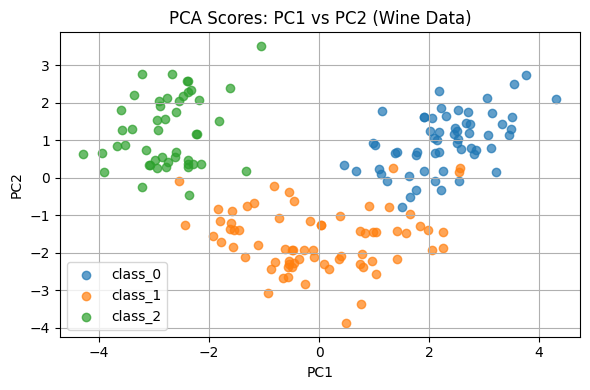

In [64]:
scores = pca_full.transform(Z)  # PCA scores for all samples
pc1 = scores[:, 0]
pc2 = scores[:, 1]

plt.figure()
for class_index, class_name in enumerate(target_names):
    mask = (y == class_index)
    plt.scatter(pc1[mask], pc2[mask], alpha=0.7, label=class_name)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scores: PC1 vs PC2 (Wine Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "pc1_pc2_scatter.png"), dpi=300)
plt.show()

Step 5: Baseline Model on Original Features

Train a multiclass logistic regression model on standardized original features.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

t0 = time.time()
baseline_pipeline.fit(X_train, y_train)
t1 = time.time()

y_pred_baseline = baseline_pipeline.predict(X_test)

acc_baseline = accuracy_score(y_test, y_pred_baseline)
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

print("Baseline logistic regression on original features")
print("Accuracy:", acc_baseline)
print("Classification report:")
print(classification_report(y_test, y_pred_baseline, target_names=target_names))
print("Confusion matrix:")
print(cm_baseline)
print("Training time (s):", t1 - t0)

Baseline logistic regression on original features
Accuracy: 0.9722222222222222
Classification report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Confusion matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]
Training time (s): 0.006583690643310547


Step 6: PCA Transformation (Train and Test)

In [66]:
# We'll use M = 10 components (around 95% variance in this dataset).
M = 10

pca_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=M)),
    ("clf", LogisticRegression(max_iter=1000))
])

t0 = time.time()
pca_pipeline.fit(X_train, y_train)
t1 = time.time()

y_pred_pca = pca_pipeline.predict(X_test)

acc_pca = accuracy_score(y_test, y_pred_pca)
cm_pca = confusion_matrix(y_test, y_pred_pca)

print(f"PCA + logistic regression (M = {M} PCs)")
print("Accuracy:", acc_pca)
print("Classification report:")
print(classification_report(y_test, y_pred_pca, target_names=target_names))
print("Confusion matrix:")
print(cm_pca)
print("Training time (s):", t1 - t0)

PCA + logistic regression (M = 10 PCs)
Accuracy: 0.9722222222222222
Classification report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Confusion matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]
Training time (s): 0.006988048553466797


For comparison, we can also examine a very aggressive reduction to only 2 PCs.


In [67]:
pca2_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)),
    ("clf", LogisticRegression(max_iter=1000))
])

t0 = time.time()
pca2_pipeline.fit(X_train, y_train)
t1 = time.time()

y_pred_pca2 = pca2_pipeline.predict(X_test)

acc_pca2 = accuracy_score(y_test, y_pred_pca2)
cm_pca2 = confusion_matrix(y_test, y_pred_pca2)

print("PCA + logistic regression (M = 2 PCs)")
print("Accuracy:", acc_pca2)
print("Classification report:")
print(classification_report(y_test, y_pred_pca2, target_names=target_names))
print("Confusion matrix:")
print(cm_pca2)
print("Training time (s):", t1 - t0)

PCA + logistic regression (M = 2 PCs)
Accuracy: 0.9166666666666666
Classification report:
              precision    recall  f1-score   support

     class_0       0.92      0.92      0.92        12
     class_1       0.87      0.93      0.90        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.92        36
   macro avg       0.93      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36

Confusion matrix:
[[11  1  0]
 [ 1 13  0]
 [ 0  1  9]]
Training time (s): 0.00978398323059082


Step 8: Compare Model Performance

,Model,Accuracy
0,Baseline (13 features),0.972222
1,PCA (10 PCs),0.972222
2,PCA (2 PCs),0.916667


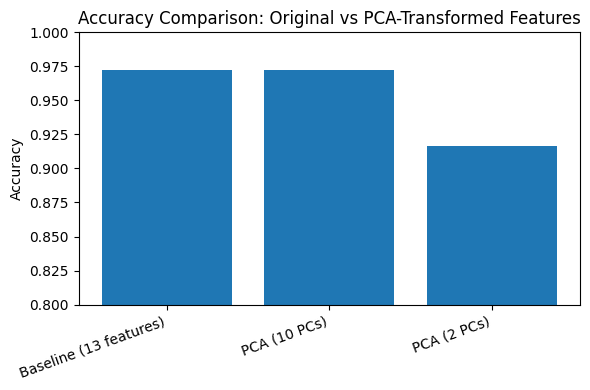

In [70]:
results = pd.DataFrame({
    "Model": ["Baseline (13 features)", "PCA (10 PCs)", "PCA (2 PCs)"],
    "Accuracy": [acc_baseline, acc_pca, acc_pca2],
})

display(results)

# Save results table as CSV
results.to_csv(os.path.join(FIG_DIR, "results_table.csv"), index=False)

# Also save as a simple PNG table using matplotlib
fig, ax = plt.subplots()
ax.axis("off")

# Prepare cell_text by rounding only the numeric column and converting all to string
cell_text_data = results.copy()
cell_text_data["Accuracy"] = np.round(cell_text_data["Accuracy"], 3)
tbl = ax.table(
    cellText=cell_text_data.values.astype(str),
    colLabels=results.columns,
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.2, 1.2)
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "results_table.png"), dpi=300, bbox_inches="tight")
plt.close(fig)

plt.figure()
plt.bar(results["Model"], results["Accuracy"])
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Original vs PCA-Transformed Features")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "accuracy_comparison.png"), dpi=300)
plt.show()